![](https://www.researchgate.net/publication/327134227/figure/fig1/AS:661996882104321@1534843764825/Variants-of-time-series-visualizations-for-the-same-four-stock-prices-over-time-In-all.png)

# Time Series Prediction for Stock-Markets by Machine Learning,Deep Leaning & Classical Statistics
**Contents**

- <a href='#2'>2. Python Dependency Libraries</a>  
- <a href='#3'>3. Classical Statistics ARIMA Modelling</a>  
    - <a href='#3.1'>3.1. Splitting of the Original DataFrame</a> 
    - <a href='#3.2'>3.2. Asset Returns & Asset Prices</a> 
    - <a href='#3.3'>3.3. Skewness, Kurtosis, Max value, Min value, Mean and Variance</a> 
    - <a href='#3.4'>3.4. Box plot of Returns</a>
    - <a href='#3.5'>3.5. Time-series plots</a>
    - <a href='#3.6'>3.6. Metrics and Model selection</a>
- <a href='#4'>4. Hybrid Machine Learning with Time Series</a>  
    - <a href='#4.1'>4.1. Data preprocessing, cross-validation, adjustment of model hyperparameters</a> 
    - <a href='#4.2'>4.2. AMAZON Prediction</a> 
    - <a href='#4.3'>4.3. FORD Prediction</a> 
    - <a href='#4.4'>4.4. GE Prediction</a>

- <a href='#5'>5.  LSTM Architecture</a>  
    - <a href='#5.1'>5.1. Close Volume insights and library upload</a> 
    - <a href='#5.2'>5.2. Data Creation for Training</a> 
    - <a href='#5.3'>5.3.  Model Training</a>        
    - <a href='#5.4'>5.4. LSTM Model Evaluation & Visualization</a>

In the project, we are analyzing four assets: 
                                                              
  
    - Amazon(AMZN)                                       Ecommerce
    - General Electric Company (GE)                      Energy 
    - Ford Motor Company (F)                             Capital Goods
    - Caterpillar Inc (CAT)                              Capital Goods
    

In the obtained historical prices, we have the following information for each of the asset:

 - **Date**: Date
 - **Open**: Open price within a date
 - **High**: The highest price within a date
 - **Low**: The lowest price within a date
 - **Close**: Close price within a date
 - **`NAME`_Adj_close**: Adjusted close price in the end of a date
 - **Volume**: Trading volume
 
In addition to this information, we are interested in daily returns of the assets. Here the latter will be calculated by using

<center> $ r^{(i)}_{t} := ln\left(\frac{P^{(i)}_{t}}{P^{(i)}_{t-1}} \right) = ln\left( P^{(i)}_{t}\right) - ln\left( P^{(i)}_{t-1} \right),$ </center>

where $ln$ stands for natural logarithm, $P^{(i)}_{t}$ is the adjusted close price of the asset ${i}$ at the time moment ${t}$, while $P^{(i)}_{t-1}$ is at the previous moment of time: ${t-1}$.

# Python Dependency Libraries

In [1]:
import pandas as pd
import numpy as np
import datetime
from pandas_datareader import data as pdr
import fix_yahoo_finance as yf
yf.pdr_override()

import warnings
warnings.simplefilter('ignore')

# Visualization
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from plotly import tools
import plotly.graph_objs as go
import chart_studio.plotly as py
import plotly.offline as po
from plotly import tools

init_notebook_mode(connected=True)

# ARIMA (ARMA) modelling
import statsmodels.api as sm
import statsmodels.tsa.api as smt
import statsmodels.tsa.stattools as ts

# Statistics
import scipy.stats as scs
from scipy.stats import skew
from scipy.stats import kurtosis
from statsmodels.tsa.stattools import kpss

# Ljung-box test (to check whether residuals are white noise)
from statsmodels.stats.diagnostic import acorr_ljungbox


# Metrics for ML (ARIMA/ARMA has embedded AIC criterion)
from sklearn.metrics import mean_absolute_error

# Hyperparameter tuning and validation
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit 
from sklearn.preprocessing import StandardScaler


#from sklearn.linear_model import LassoCV, RidgeCV
from sklearn.linear_model import Ridge, Lasso

In [2]:
stocks_start = datetime.datetime(2014, 1, 1)
stocks_end = datetime.datetime(2019, 1, 1)

In [3]:
tickers=['AMZN','GE','F','CAT']

def get(tickers, startdate, enddate):
    def data(ticker):
        return (pdr.get_data_yahoo(ticker, start=startdate, end=enddate))
    datas = map(data, tickers)
    return(pd.concat(datas, keys=tickers, names=['Ticker', 'Date']))
               
all_data = get(tickers, stocks_start, stocks_end)

[*********************100%***********************]  1 of 1 downloaded
[*********************100%***********************]  1 of 1 downloaded
[*********************100%***********************]  1 of 1 downloaded
[*********************100%***********************]  1 of 1 downloaded


In [4]:
all_data=all_data.reset_index()
all_data.head()

Ticker       Date    Open    High     Low   Close  Adj Close     Volume
0   AMZN 2013-12-31  394.58  398.83  393.80  398.79     398.79  1996500.0
1   AMZN 2014-01-02  398.80  399.36  394.02  397.97     397.97  2137800.0
2   AMZN 2014-01-03  398.29  402.71  396.22  396.44     396.44  2210200.0
3   AMZN 2014-01-06  395.85  397.00  388.42  393.63     393.63  3170600.0
4   AMZN 2014-01-07  395.04  398.47  394.29  398.03     398.03  1916000.0

In [5]:
all_data.rename(columns={'Adj Close': 'Adj_Close'}, inplace=True)
all_data.columns

Index(['Ticker', 'Date', 'Open', 'High', 'Low', 'Close', 'Adj_Close',
       'Volume'],
      dtype='object')

In [6]:
all_data.dtypes

Ticker               object
Date         datetime64[ns]
Open                float64
High                float64
Low                 float64
Close               float64
Adj_Close           float64
Volume              float64
dtype: object

In [7]:
all_data.isna().sum()

Ticker       0
Date         0
Open         1
High         1
Low          1
Close        1
Adj_Close    1
Volume       1
dtype: int64

In [8]:
all_data.fillna(method='ffill',inplace=True)
all_data.isna().sum()

Ticker       0
Date         0
Open         0
High         0
Low          0
Close        0
Adj_Close    0
Volume       0
dtype: int64

In [9]:
for i,v in all_data['Low'].iteritems():
    if pd.notnull(v):
        pass
    else:
        print(i)

**What Is a Return?**



A return, also known as a financial return, in its simplest terms, is the money made or lost on an investment over some period of time.


A return can be expressed nominally as the change in dollar value of an investment over time. A return can also be expressed as a percentage derived from the ratio of profit to investment. Returns can also be presented as net results (after fees, taxes, and inflation) or gross returns that do not account for anything but the price change. 


**KEY TAKEAWAYS**
- A return is the change in price on an asset, investment, or project over time, which may be represented in terms of price change or percentage change.
- A positive return represents a profit while a negative return marks a loss.
- Returns are often annualized for comparison purposes, while a holding period return calculates the gain or loss during the entire period an investment was held.
- Real return accounts for the effects of inflation and other external factors, while nominal return only is interested in price change. Total return for stocks includes price change as well as dividend and interest payments.

In [10]:
# function for adding log-returns column to dataframes 
def add_log_returns(df):
            adj_closing_price = df['Adj_Close']
            log_array = np.log(np.array(adj_closing_price))
            log_return_array = log_array - np.append(log_array[1:], np.nan)
            log_return_df = pd.DataFrame(log_return_array,columns=['stock_returns'])
            df['stock_returns']=log_return_df['stock_returns']
            return df

In [11]:
all_data=add_log_returns(all_data)
all_data.head()

Ticker       Date    Open    High     Low   Close  Adj_Close     Volume  \
0   AMZN 2013-12-31  394.58  398.83  393.80  398.79     398.79  1996500.0   
1   AMZN 2014-01-02  398.80  399.36  394.02  397.97     397.97  2137800.0   
2   AMZN 2014-01-03  398.29  402.71  396.22  396.44     396.44  2210200.0   
3   AMZN 2014-01-06  395.85  397.00  388.42  393.63     393.63  3170600.0   
4   AMZN 2014-01-07  395.04  398.47  394.29  398.03     398.03  1916000.0   

   stock_returns  
0       0.002058  
1       0.003852  
2       0.007113  
3      -0.011116  
4      -0.009726

In [12]:
all_data.Ticker.unique()

array(['AMZN', 'GE', 'F', 'CAT'], dtype=object)

In [13]:
all_data.columns

Index(['Ticker', 'Date', 'Open', 'High', 'Low', 'Close', 'Adj_Close', 'Volume',
       'stock_returns'],
      dtype='object')

For convenience, we present two functions. One to create a dataframe consisting of only adjusted close prices of our assets, while the other one is to create a dataframe consisting of only asset returns.

In [14]:
def asset_adj_close(df,tickers):  
    f=pd.DataFrame()
    f=df[df['Ticker']== 'AMZN']
    f=f[['Date']]
    for i in tickers:
        x =df[df['Ticker']== i]
        x= x[['Date','Close']]
        x.rename(columns={'Close': '%sClose' % i}, inplace=True)
        x.reset_index(drop=True)
        f = pd.merge(x, f, on='Date',how="left")   
    return f


In [15]:
adj_close = asset_adj_close(all_data, tickers)
adj_close.head(2)

Date  CATClose  FClose  GEClose  AMZNClose
0 2013-12-31     90.81   15.43    26.95     398.79
1 2014-01-02     89.87   15.44    26.44     397.97

In [16]:
adj_close.index=adj_close.Date
adj_close.drop(columns='Date',axis=1, inplace=True)
adj_close.head()

CATClose  FClose  GEClose  AMZNClose
Date                                            
2013-12-31     90.81   15.43    26.95     398.79
2014-01-02     89.87   15.44    26.44     397.97
2014-01-03     89.82   15.51    26.42     396.44
2014-01-06     88.64   15.58    26.21     393.63
2014-01-07     88.93   15.38    26.24     398.03

In [17]:
def asset_returns(df, tickers):
    f=pd.DataFrame()
    f=df[df['Ticker']== 'AMZN']
    f=f[['Date']]
    for i in tickers:
        x =df[df['Ticker']== i]
        x= x[['Date','stock_returns']]
        #x = pd.DataFrame(log_return_array,columns=['%stock_returns' % tickers[i]])
        x.rename(columns={'stock_returns': '%sreturns' % i}, inplace=True)
        x.reset_index(drop=True)
        f = pd.merge(x, f, on='Date')   
    return f

In [18]:
returns = asset_returns(all_data, tickers)
returns.index=returns.Date
returns.drop(columns='Date',axis=1, inplace=True)
returns.head()

CATreturns  Freturns  GEreturns  AMZNreturns
Date                                                    
2013-12-31    0.010304 -0.000914   0.018962     0.002058
2014-01-02    0.000545 -0.004560   0.000912     0.003852
2014-01-03    0.013314 -0.004539   0.007786     0.007113
2014-01-06   -0.003311  0.012762  -0.000919    -0.011116
2014-01-07   -0.002339 -0.010041   0.002760    -0.009726

#  Classical Statistics ARIMA Modelling

The structure of this section as follows

- Correlation and Pairplot
- A normal quantile-quantile plot and Comparison of their Kernel Density Estimation (KDE) to the closest parametric normal distribution
- Skewness, Kurtosis, Max value, Min value, Mean and Variance
- Box plot
- Time Series plot
- Correlation function and Partial correlation function

Here we provide a correlation table and a scatter plot against each other for both prices and returns of General Electric(GE), Ford Motors(F),Caterpillar(CAT), Amazon (AMZN), . Comparison of Pearson and Spearman correlations let us know the affection of large outliers on general picture of the assets movement.

First we present two auxiliary functions

## Asset Returns &  Asset Prices

In [19]:
def correlation(df,lis,days):
    for i in lis:
        #correlation
        correlation = df[-days:].corr(method=i)
        #tick labels
        matrix_cols = correlation.columns.tolist()
        #convert to array
        corr_array  = np.array(correlation)
        #Plotting

        trace = go.Heatmap(z = corr_array,
                   x = matrix_cols,
                   y = matrix_cols,
                   xgap = 2,
                   ygap = 2,
                   colorscale='Viridis',
                   colorbar   = dict() ,
                  )
        layout = go.Layout(dict(title = '{} correlation'.format(i),
                        autosize = False,
                        height  = 720,
                        width   = 800,
                        margin  = dict(r = 0 ,l = 210,
                                       t = 25,b = 210,
                                     ),
                        yaxis   = dict(tickfont = dict(size = 9)),
                        xaxis   = dict(tickfont = dict(size = 9)),
                       )
                  )
        fig = go.Figure(data = [trace],layout = layout)
        fig.show()
        

In [20]:
lis=['pearson','spearman']
correlation(adj_close,lis,days=252)


In [21]:
correlation(returns,lis,days=252)

From the figure right above one can see that correlation between asset returns does not change much between two types of correlations. The returns tend to comoving within 252 days time interval.

In [22]:
def pairplot(df, days=252, width=9, height=9):
    g = sns.pairplot(df[-days:]);
    g.fig.set_size_inches(width,height)
    plt.show()

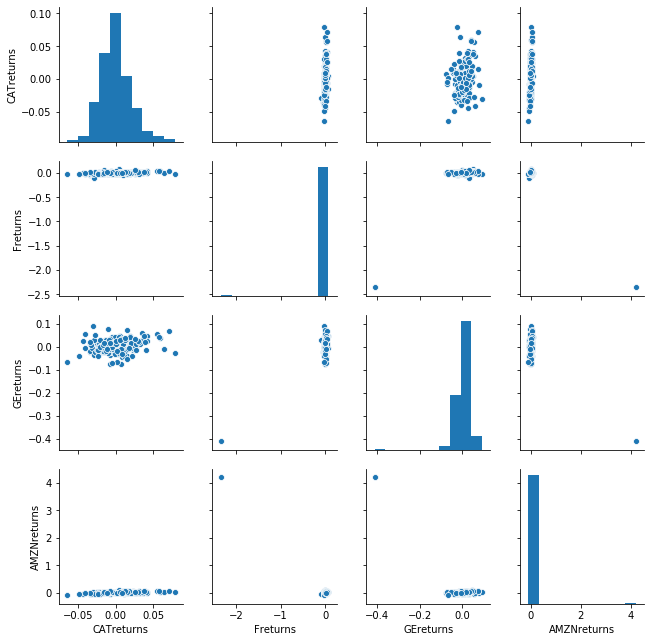

In [23]:
pairplot(returns, width=9, height=9)

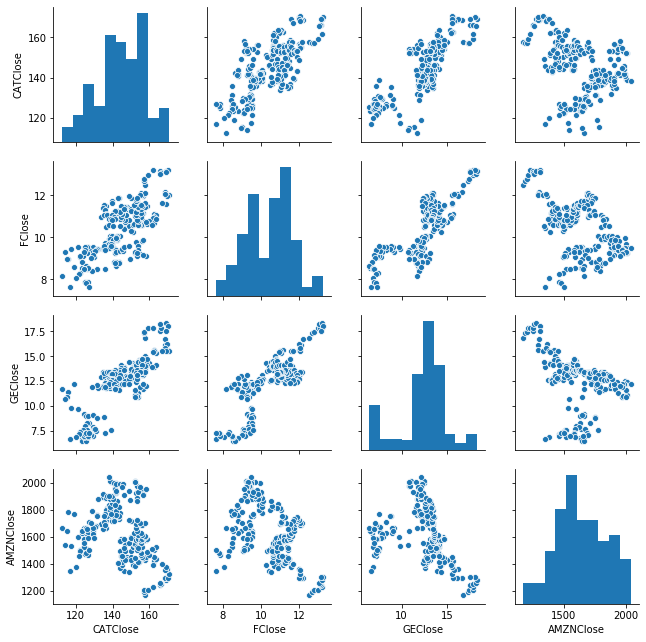

In [24]:
pairplot(adj_close, width=9, height=9)

The above is the scatter plot for adjusted close prices. This allows us to see general tendency of asset pairs.

According to the correlation analysis, the assets considered here tend to comoving. However, we should also remember what time-interval is considered. Here we take into account 252 days interval corresponding to about 1 trading year. If some other time interval is of interest, then correlation coefficients for all of the assets change appropriately. It is not possible to know in advance whether the correlation between the assets will be higher, remain the same or lower with changing a time-period. But such an analysis demonstrates an estimation of their possible correlation values.

A normal quantile-quantile plot and Comparison of their Kernel Density Estimation (KDE) to the closest parametric normal distribution

### Asset Prices

In [25]:
def norm_function(x, mu, sigma):
    return (1/(sigma*np.sqrt(2*np.pi))) * np.exp(-(x-mu)**2 / (2*sigma**2))

In [26]:
def qqplot_returns(df, symbols, option='returns', size=(10,5), sharex=False, sharey=False, wspace=0.6, hspace=0.4):

    nrows = len(symbols)
    if nrows != 1:
        fig, axes = plt.subplots(nrows=nrows, ncols=2, sharex=sharex, sharey=sharey, figsize=size)
        plt.subplots_adjust(wspace=wspace, hspace=hspace)
        for i in range(nrows):
            
            if option == 'returns':
                name = '%s' % symbols[i]
                name_return = '%sreturns' % symbols[i]
            elif option == 'Close':
                name = '%s' % symbols[i]
                name_return = '%sClose' % symbols[i]
                
            probplot = sm.ProbPlot(df[name_return], dist='norm')  
            fig = probplot.qqplot(line='q', ax=axes[i,0])
            axes[i,0].set_title('Normal Q-Q Plot (%s)' % name)

            sns.distplot(df[name_return], kde=True, hist=False, ax=axes[i,1], color='black')
            count, mean, std, min_, q1, mean, q3, max_ = df[name_return].describe()
            xx = np.linspace(min_, max_, 1000)
            axes[i,1].plot(xx, norm_function(xx, mean, std), '--', color='red')            
            axes[i,1].set_title(name)
            axes[i,1].set_xlabel('')
        plt.show()
    
    else:        
        if option == 'returns':
            name = '%s' % symbols[1]
            name_return = '%sreturns' % symbols[1]
        elif option == 'Close':
            name = '%s' % symbols[1]
            name_return = '%sClose' % symbols[1]
        
        nrows = 1
        fig, axes = plt.subplots(nrows=nrows, ncols=2, sharex=sharex, sharey=sharey, figsize=size)
        plt.subplots_adjust(wspace=wspace, hspace=hspace)
        name = '%s' % symbols[0]
        name_return = '%sreturns' % symbols[0]

        probplot = sm.ProbPlot(df[name_return], dist='norm')  
        fig = probplot.qqplot(line='q', ax=axes[0])
        axes[0].set_title('Normal Q-Q Plot (%s)' % name)

        sns.distplot(df[name_return], kde=True, hist=False, ax=axes[1], color='black')
        count, mean, std, min_, q1, mean, q3, max_ = df[name_return].describe()
        xx = np.linspace(min_, max_, 1000)
        axes[1].plot(xx, norm_function(xx, mean, std), '--', color='red')            
        axes[1].set_title(name)
        axes[1].set_xlabel('')
        plt.show()

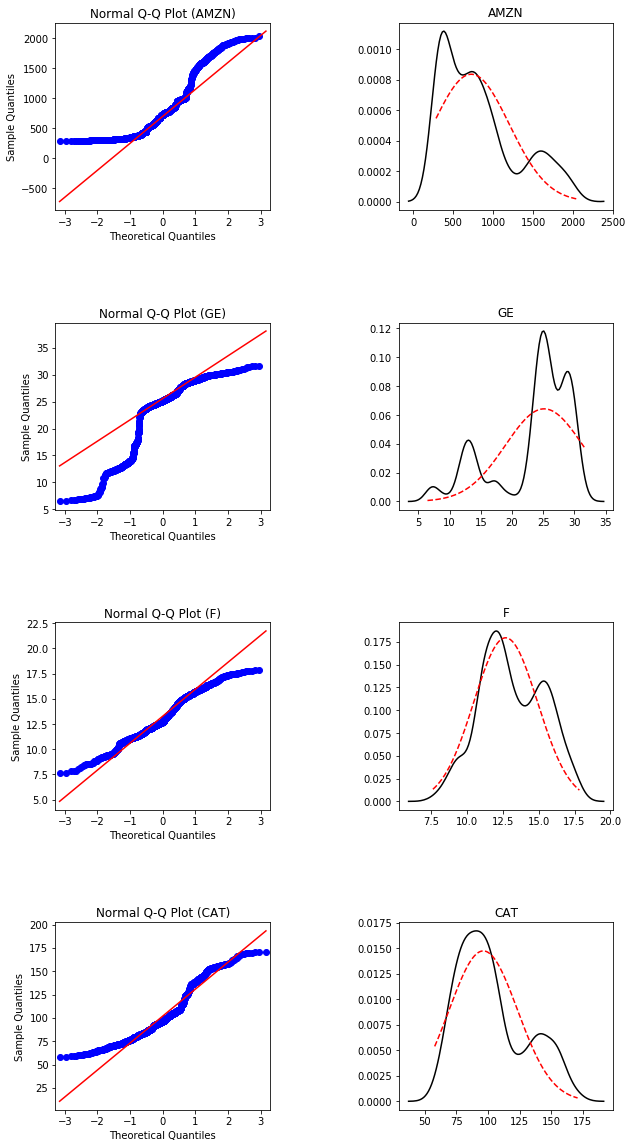

In [27]:
qqplot_returns(adj_close, tickers, option='Close',
               size=(10,20), sharex=False, sharey=False, wspace=0.6, hspace=0.6)

On the left-hand side the normal quantile-quantile plots are shown, while on the right-hand side kernel density estimate of returns and their closest normal distribution are illustrated. Red lines correspond to normal distribution.

We see that some of adjusted close prices have bi-modal distributions while some others have even more complex structure which does not appear to be normal even close.

### Asset Returns

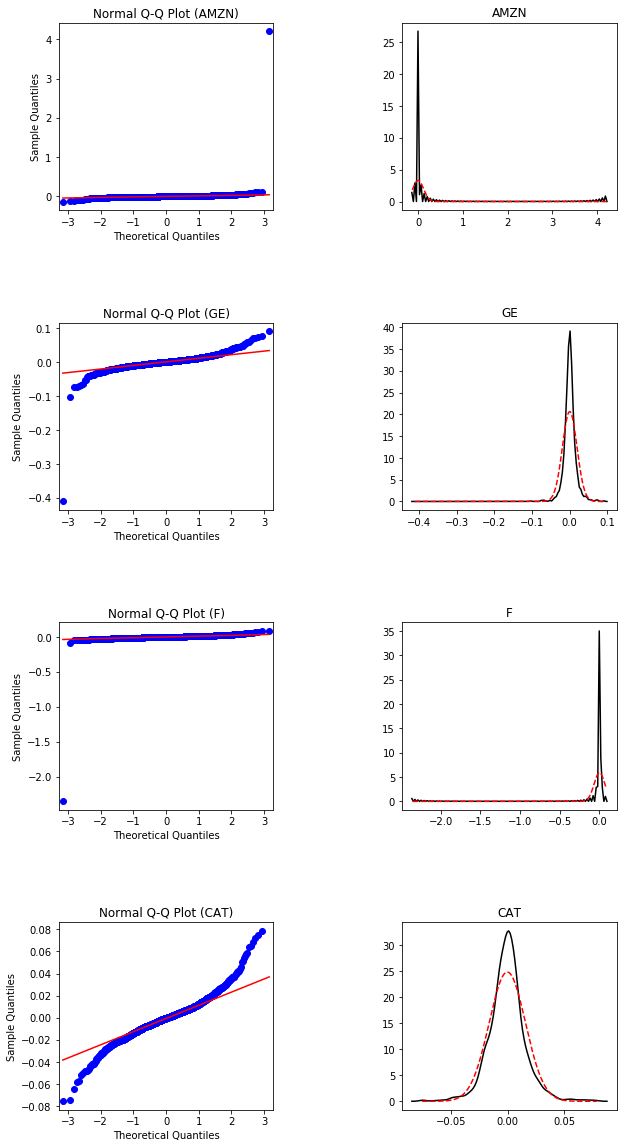

In [28]:
qqplot_returns(returns, tickers, option='returns',
               size=(10,20), sharex=False, sharey=False, wspace=0.6, hspace=0.6)

Red lines correspond to normal distribution. Note that the distribution is not normal as demonstrated by both kinds of plots demonstrating fatter tails and higher kurtosis. However, their structure is closer to the normal distribution than that of adjusted close price.

On this stage of the work we may colcude that fat tails will become a problem for our ARIMA or ARMA modelling since it may be that we will not encompass all the time-series information due to that. Let's keep this notion in mind and move on.

##  Skewness, Kurtosis, Max value, Min value, Mean and Variance

Now let's gather more statistics about target values. Precisely speaking, their Skewness, Kurtosis, Max returns, Max loss, Mean and Variances.

In [29]:
def stats(df, symbols):
    stat = pd.DataFrame(index=symbols, 
                                columns=['Skewness','Kurtosis','Max value',
                                         'Min value','Mean','Variance'])
    stat['Skewness'] = skew(df, axis=0)
    stat['Kurtosis'] = kurtosis(df, axis=0)
    stat['Max value'] = df.agg('max').values
    stat['Min value'] = df.agg('min').values
    stat['Mean'] = df.agg('mean').values
    stat['Variance'] = df.agg('var').values

    return stat

In [30]:
returns.columns

Index(['CATreturns', 'Freturns', 'GEreturns', 'AMZNreturns'], dtype='object')

In [31]:
stats(adj_close.loc[:, ['CATClose', 'FClose', 'GEClose', 'AMZNClose']], tickers)

Skewness  Kurtosis  Max value  Min value        Mean       Variance
AMZN  0.668005 -0.571592     170.89      57.91  103.002563     733.471750
GE         NaN       NaN      17.84       7.63   13.150699       4.944451
F          NaN       NaN      31.66       6.45   23.473884      38.617185
CAT        NaN       NaN    2039.51     286.95  822.919396  227446.154340

In [32]:
stats(returns.loc[:, [ 'CATreturns', 'Freturns', 'GEreturns', 'AMZNreturns']], tickers)

Skewness     Kurtosis  Max value  Min value      Mean  Variance
AMZN        NaN          NaN   0.078592  -0.075632 -0.000407  0.000259
GE   -33.003564  1140.551350   0.085298  -2.352928 -0.001521  0.004612
F     -7.542314   163.700335   0.091195  -0.410510  0.000569  0.000373
CAT   34.056877  1189.161117   4.207259  -0.132178  0.002288  0.014444

## Box plot of Returns

Box plot will help us to get the precise information about outliers and how they fit in the whole picture.

### Asset Price & Asset Returns

In [33]:
def asset_box_plot(df, symbols, title=None, width=700, height=400, 
                   jitter=0.2, pointpos=-1.5, boxpoints = 'suspectedoutliers'):
    
    data=[]
    for i in range(len(symbols)):
        trace = go.Box(y = df.iloc[:,i],
                       name = symbols[i],
                       jitter=jitter,
                       pointpos=pointpos,
                       boxpoints = boxpoints)

        data.append(trace)
        
        
    layout = go.Layout(title = title,
                       autosize=False,
                       width=width,
                       height=height)

    fig = go.Figure(data=data,layout=layout)

    iplot(fig)

In [34]:
asset_box_plot(adj_close, tickers, title='Adj close price', boxpoints = 'suspectedoutliers')

In [35]:
asset_box_plot(returns, tickers, title='Returns')

## Time-series plots

In [36]:
def plot_prices(df, symbols, width=1000, height=400):
    traces = []
    for asset in symbols:
        trace = go.Scatter(
                    x=df.index,
                    y=df['%sClose' % asset],
                    name = '%s price' % asset)
        traces.append(trace)
        
    layout = go.Layout(title='Adj close price history', 
                       autosize=False,
                       width=width,
                       height=height)
    fig = go.Figure(data=traces, layout=layout) 
    
    return iplot(fig, show_link=False)

**Asset Prices**

In [37]:
plot_prices(adj_close, tickers)

In [38]:

def plot_returns(df, symbols, width=1000, height=400):
    traces = []
    for asset in symbols:
        trace = go.Scatter(
                    x=df.index,
                    y=df['%sreturns' % asset],
                    name = '%s returns' % asset,
                    opacity=0.8)
        traces.append(trace)
        
    layout = go.Layout(title='Returns history',
              autosize=False,
              width=width,
              height=height
                      )
    fig = go.Figure(data=traces, layout=layout) 
    
    return iplot(fig, show_link=False)



**Asset Returns**

In [39]:
plot_returns(returns, tickers)

It might be useful to see all the return values separately.

In [40]:
# A function for plotting history of log returns for all assets
def plot_returns_indiv(df, symbols, width=1200, height=800):
    traces = []
    count = 0
    for asset in symbols:
        trace = go.Scatter(
                    x=df.index,
                    y=df['%sreturns' % asset],
                    name = '%s returns' % asset,
                    opacity=0.8)
        traces.append(trace)
        count += 1
        
    fig = tools.make_subplots(rows=int(len(symbols)/2+0.5), cols=2, shared_yaxes=True)

    i = 0
    while i < count:
        for ncol in [1,2]:
            for nrow in range(1, int(len(symbols)/2+1.5)):
                fig.append_trace(traces[i], nrow, ncol)
                i += 1
        
    fig['layout'].update(width=width, height=height, title='Returns History')
 
    return iplot(fig, show_link=False)

In [41]:
plot_returns_indiv(returns, tickers);

C:\Users\aniruddha.choudhury\AppData\Local\Continuum\anaconda3\envs\kdlsd\lib\site-packages\plotly\tools.py:465: DeprecationWarning:

plotly.tools.make_subplots is deprecated, please use plotly.subplots.make_subplots instead



From the figures of the return time-series one can see that 
The assets do not have long-term deviations from the mean and are mainly oscillating over some constant values that is almost zero. This is a property of stationary process.
There are periods of high volatility followed by periods of relatively tranquility (volatility clustering).
One can also notice that volatility clustering does not indicate a lack of stationarity but rather can be viewed as a type of dependence in the conditional variance of each series.

Next we are going to determine whether price and return time-series are stationary by finding Autocorrelation Function (ACF) and Partial Autocorrelation Function (PACF).

###  Autocorrelation Function (ACF) and Partial Autocorrelation Function (PACF)

When a time series is observed, a natural question is whether it appears to be stationary. In this section, we plot ACF and PACF in order to check the series on the presence of stationarity. We also perform Augmented Dickey-Fuller test as well as Kwiatkowski-Phillips-Schmidt-Shin test. The former tests null hypothesis that timeseries is not stationary against an alternative hypothesis that the time-series is stationary, while the latter test is designed to test null stationarity against an alternative of non-stationarity.

In [42]:
adj_close.isna().sum()

CATClose     0
FClose       1
GEClose      1
AMZNClose    1
dtype: int64

In [43]:
adj_close['FClose'].fillna((adj_close['FClose'].mean()),inplace=True)
adj_close['GEClose'].fillna((adj_close['GEClose'].mean()),inplace=True)
adj_close['AMZNClose'].fillna((adj_close['AMZNClose'].mean()),inplace=True)
adj_close.isna().sum()

CATClose     0
FClose       0
GEClose      0
AMZNClose    0
dtype: int64

In [44]:
def stationary_analysis(df, symbols, lags, option='price', figsize=(10,20), wspace=0.3, hspace=0.5):   
    nrows = df.shape[1]
    fig, axes = plt.subplots(nrows=nrows, ncols=2, figsize=figsize)
    plt.subplots_adjust(wspace=0.3, hspace=0.5)
    row = 0
    for asset in symbols:
        if option == 'price':
            smt.graphics.plot_acf(df['%sClose' % asset], lags=lags, ax=axes[row,0])
            smt.graphics.plot_pacf(df['%sClose' % asset], lags=lags, ax=axes[row,1])
            axes[row,0].set_title('%s Adj close (ACF)' % asset)
            axes[row,1].set_title('%s Adj close (PACF)' % asset)
            row += 1
        elif option == 'return':
            smt.graphics.plot_acf(df['%sreturns' % asset], lags=lags, ax=axes[row,0])
            smt.graphics.plot_pacf(df['%sreturns' % asset], lags=lags, ax=axes[row,1])
            axes[row,0].set_title('%s returns (ACF)' % asset)
            axes[row,1].set_title('%s returns (PACF)' % asset)
            row += 1     
    
    return plt.show()

In [45]:
def adf_kpss(df, symbols, option='price'):
    adf_kpss = pd.DataFrame(index=asset_names, columns=['ADF','KPSS'])
    
    if option == 'price':
        adf_price = []
        kpss_price = []
        for i in range(len(symbols)):
            adf_price.append(ts.adfuller(adj_close.iloc[:,i])[1])
            kpss_price.append(kpss(adj_close.iloc[:,i])[1])
        adf_kpss['ADF'] = np.array(adf_price)
        adf_kpss['KPSS'] = np.array(kpss_price)
    
    elif option == 'returns':
        adf_returns = []
        kpss_returns = []
        for i in range(len(asset_names)):
            adf_returns.append(ts.adfuller(returns.iloc[:,i])[1])
            kpss_returns.append(kpss(returns.iloc[:,i])[1])
        adf_kpss['ADF'] = np.array(adf_returns)
        adf_kpss['KPSS'] = np.array(kpss_returns)
        
    return adf_kpss

**Asset Prices**

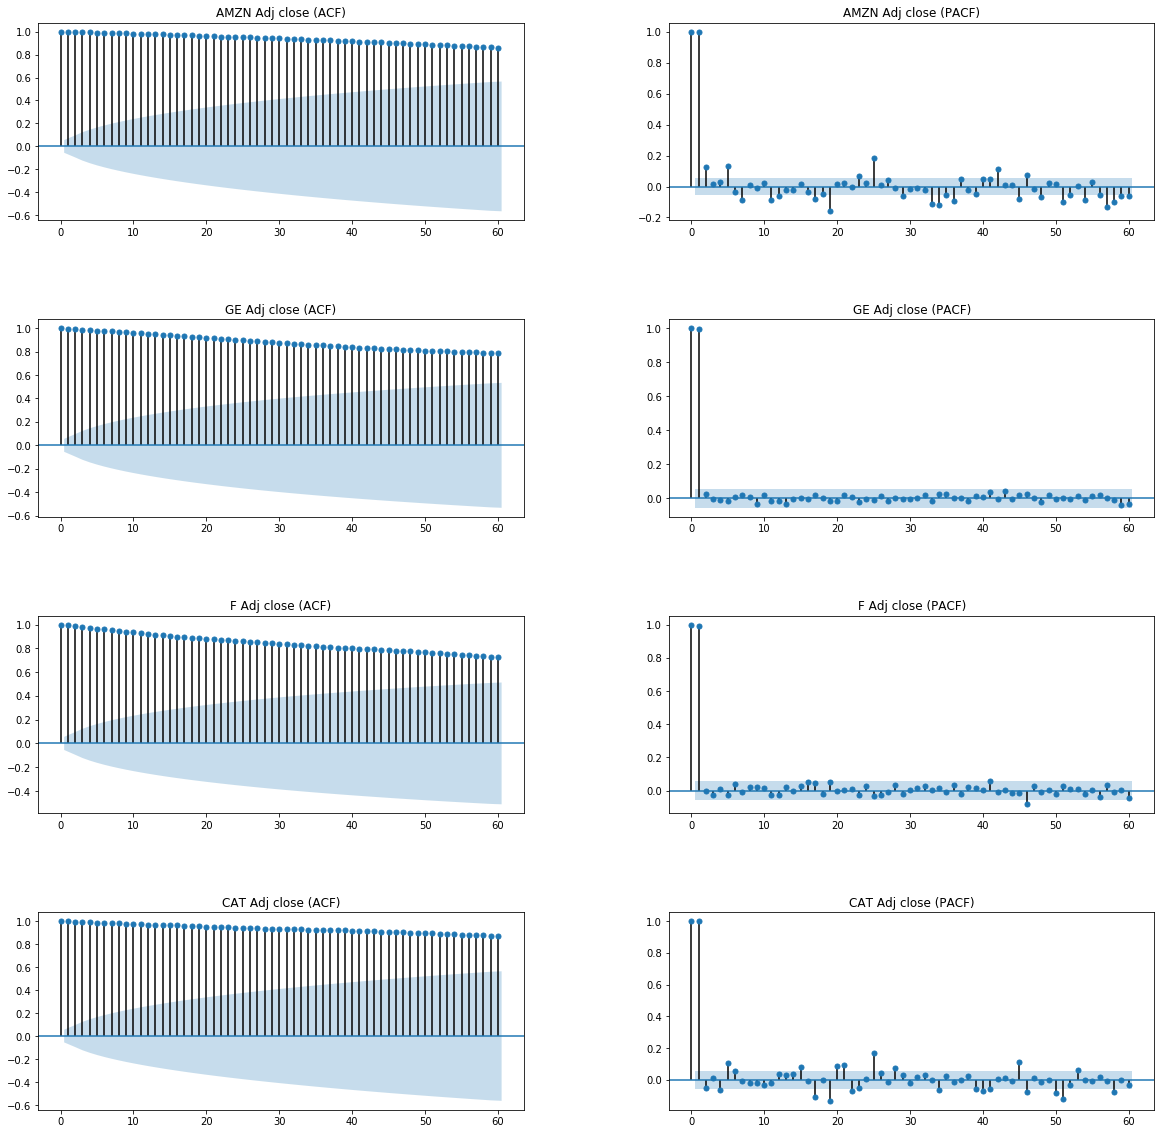

In [46]:
stationary_analysis(adj_close, tickers, option='price', lags=60, figsize=(20,20))

Autocorrelation Function (ACF) and Partial Autocorrelation Function (PACF) for four-price time-series General Electric(GE), Ford Motors(F),Caterpillar(CAT), Amazon (AMZN), .One can see that each ACF shows a very slow (barely noticeable), linear decay pattern which is typical of a nonstationary time series. Besides, PACF has one significant spike at lag 1 (lag 0 is not accounted for) meaning that (almost) all the higher-order autocorrelations are effectively explained by the lag 1 autocorrelation. Such ACF and PACF are typical for non-stationary time-series. There are also some test-statistic to either support or reject our assumptions.
To prove our initial guessing about the behavior of price time-series, we perform Augmented Dickey-Fuller (ADF) test and Kwiatkowski–Phillips–Schmidt–Shin (KPSS) test.

In [47]:
adf_kpss_price = pd.DataFrame(index=tickers, columns=['ADF','KPSS'])
adf_price = []
kpss_price = []
for i in range(len(tickers)):
    adf_price.append(ts.adfuller(adj_close.iloc[:,i])[1])
    kpss_price.append(kpss(adj_close.iloc[:,i])[1])

C:\Users\aniruddha.choudhury\AppData\Local\Continuum\anaconda3\envs\kdlsd\lib\site-packages\statsmodels\tsa\stattools.py:1708: InterpolationWarning:

p-value is smaller than the indicated p-value

C:\Users\aniruddha.choudhury\AppData\Local\Continuum\anaconda3\envs\kdlsd\lib\site-packages\statsmodels\tsa\stattools.py:1708: InterpolationWarning:

p-value is smaller than the indicated p-value

C:\Users\aniruddha.choudhury\AppData\Local\Continuum\anaconda3\envs\kdlsd\lib\site-packages\statsmodels\tsa\stattools.py:1708: InterpolationWarning:

p-value is smaller than the indicated p-value

C:\Users\aniruddha.choudhury\AppData\Local\Continuum\anaconda3\envs\kdlsd\lib\site-packages\statsmodels\tsa\stattools.py:1708: InterpolationWarning:

p-value is smaller than the indicated p-value



In [48]:
adf_kpss_price['ADF'] = np.array(adf_price)
adf_kpss_price['KPSS'] = np.array(kpss_price)
adf_kpss_price

ADF  KPSS
AMZN  0.749588  0.01
GE    0.836510  0.01
F     0.993646  0.01
CAT   0.913634  0.01

This table contains p-values information on whether or not to reject the null hypothesis. Since ADF tests gives p-values larget than 0.05, we do not have enough information to reject the null hypothesis stating that time-series is not stationary at 95% confidence level. Besides, KPSS p-values shows that we reject the null hypothesis that time series is stationary at 95% confidence level. The latter is probably a deviation due to insufficient data. In general, combination of ADF and KPSS test results proves that time-series of the adjusted close prices are not stationary.

**Asset Returns**

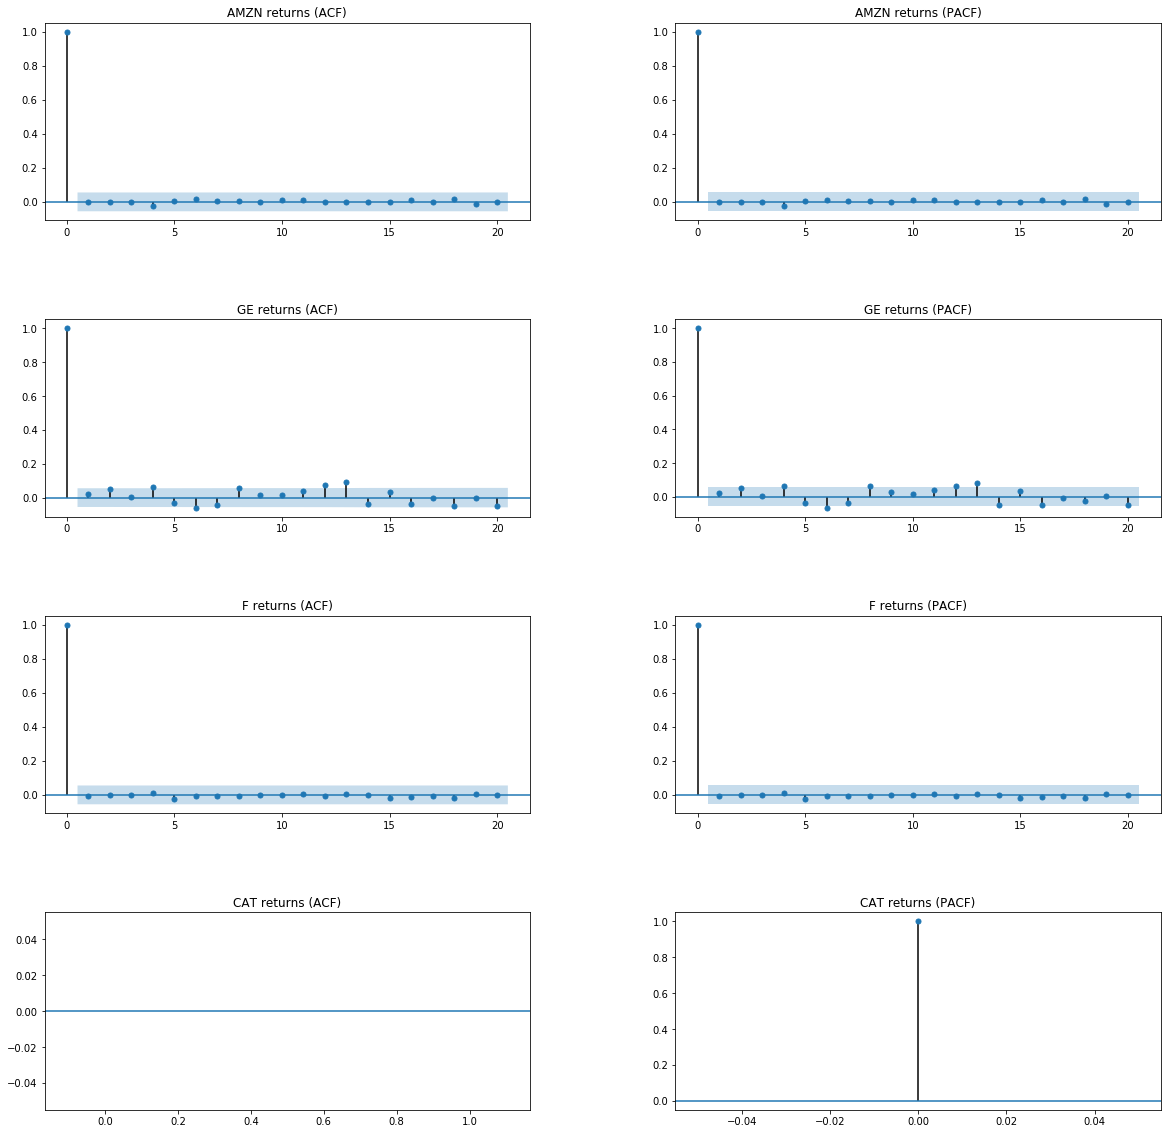

In [49]:
stationary_analysis(returns, tickers, option='return', lags=20, figsize=(20,20))

ACF and PACF demonstrate that time-series of returns should be stationary. Let's support this by performing ADF and KPSS tests.

In [50]:
adf_kpss_returns = pd.DataFrame(index=tickers, columns=['ADF','KPSS'])

adf_returns = []
kpss_returns = []
for i in range(len(tickers)):
    adf_returns.append(ts.adfuller(returns.iloc[:,i])[1])
    kpss_returns.append(kpss(returns.iloc[:,i])[1])

C:\Users\aniruddha.choudhury\AppData\Local\Continuum\anaconda3\envs\kdlsd\lib\site-packages\statsmodels\tsa\stattools.py:1710: InterpolationWarning:

p-value is greater than the indicated p-value

C:\Users\aniruddha.choudhury\AppData\Local\Continuum\anaconda3\envs\kdlsd\lib\site-packages\statsmodels\tsa\stattools.py:1710: InterpolationWarning:

p-value is greater than the indicated p-value

C:\Users\aniruddha.choudhury\AppData\Local\Continuum\anaconda3\envs\kdlsd\lib\site-packages\statsmodels\tsa\stattools.py:1710: InterpolationWarning:

p-value is greater than the indicated p-value



In [51]:
adf_kpss_returns['ADF'] = np.array(adf_returns)
adf_kpss_returns['KPSS'] = np.array(kpss_returns)
adf_kpss_returns

ADF  KPSS
AMZN       NaN   NaN
GE    0.000002   0.1
F     0.000007   0.1
CAT   0.838735   0.1

From the table we see that for all the assets except CAT, ADF null-hypothesis stating that time-series is not stationary may be rejected with 95% confidence level, while p-values of KPSS test indicate that there is not enough information to reject its null-hypothesis that time series is stationary at 95% confidence level. Then we may conclude that time-series of returns is stationary meaning that we can use ARMA for  CAT,GE,AMZN  and F assets. However, we should be careful with GE. To be on the safe side, we include 
𝑑
d
parameter while doing ARIMA grid search for GE.

##  Metrics and Model selection

**ARIMA Model and Box-Ljung test**

Here we build ARIMA model for stationary time-series of asset returns following the steps:
Identify p and q values of ARIMA by using grid search incorporating Akaike information criterion metrics. 
Plot figures and investigate residuals distribution (whether they have white noise properties or not)
Apply Box-Ljung test to ARIMA residuals (null hypothesis is that residuals are white noise)
Make predictions by using ARIMA models

In [52]:
# Defined the function to fit ARIMA(p, d, q) model
# Selection of best order and final model based on aic

def arima_model(df, symbol):
    print(symbol)
    asset = df['%sreturns' % symbol]  
    print(df.columns)
    best_aic = np.inf 
    best_order = None
    best_mdl = None

    pq_rng = range(6) 
    d_rng = range(1) 
    
    for p in pq_rng:
        for d in d_rng:
            for q in pq_rng:
                try:
                    tmp_mdl = smt.ARIMA(asset, order=(p,d,q)).fit(method='mle', trend='nc')
                    tmp_aic = tmp_mdl.aic
                    if tmp_aic < best_aic:
                        best_aic = tmp_aic
                        best_order = (p, d, q)
                        best_mdl = tmp_mdl
                except: continue
    return best_aic, best_order, best_mdl

In [53]:
def tsplot(y, lags=None, figsize=(10, 8), style='bmh', name='asset'):
    Residual=pd.DataFrame(y)
    Residual=Residual[:-1]
    import plotly.express as px
    fig = px.line(y, x=Residual.index, y=Residual.values)
    fig.update_layout(title='Time Series Analysis Plots: %s' % name,
                          xaxis_title='Date',
                          yaxis_title='Residual Error',
                         height=300, width=1000,
                         legend=dict(x=-.1, y=1.5))
    fig.show()
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        acf_ax = plt.subplot2grid(layout, (0, 0))
        pacf_ax = plt.subplot2grid(layout, (0, 1))
        qq_ax = plt.subplot2grid(layout, (1, 0))
        pp_ax = plt.subplot2grid(layout, (1, 1))
        
    
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.5)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.5)
        sm.qqplot(y, line='s', ax=qq_ax)
        qq_ax.set_title('QQ Plot')        
        scs.probplot(y, sparams=(y.mean(), y.std()), plot=pp_ax)
        plt.tight_layout()
    



In [54]:
returns.head()

CATreturns  Freturns  GEreturns  AMZNreturns
Date                                                    
2013-12-31    0.010304 -0.000914   0.018962     0.002058
2014-01-02    0.000545 -0.004560   0.000912     0.003852
2014-01-03    0.013314 -0.004539   0.007786     0.007113
2014-01-06   -0.003311  0.012762  -0.000919    -0.011116
2014-01-07   -0.002339 -0.010041   0.002760    -0.009726

In [55]:
#removing the last columns
returns=returns[:-1]

In [56]:
aic_dict = {}
order_dict = {}
mdl_dict = {}
for symbol in tickers:
    aic_dict[symbol], order_dict[symbol], mdl_dict[symbol] = arima_model(returns, symbol)

AMZN
Index(['CATreturns', 'Freturns', 'GEreturns', 'AMZNreturns'], dtype='object')


C:\Users\aniruddha.choudhury\AppData\Local\Continuum\anaconda3\envs\kdlsd\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

C:\Users\aniruddha.choudhury\AppData\Local\Continuum\anaconda3\envs\kdlsd\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

C:\Users\aniruddha.choudhury\AppData\Local\Continuum\anaconda3\envs\kdlsd\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

C:\Users\aniruddha.choudhury\AppData\Local\Continuum\anaconda3\envs\kdlsd\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning:

A date index has been provided, but it

C:\Users\aniruddha.choudhury\AppData\Local\Continuum\anaconda3\envs\kdlsd\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

C:\Users\aniruddha.choudhury\AppData\Local\Continuum\anaconda3\envs\kdlsd\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

C:\Users\aniruddha.choudhury\AppData\Local\Continuum\anaconda3\envs\kdlsd\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

C:\Users\aniruddha.choudhury\AppData\Local\Continuum\anaconda3\envs\kdlsd\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning:

A date index has been provided, but it

GE
Index(['CATreturns', 'Freturns', 'GEreturns', 'AMZNreturns'], dtype='object')


C:\Users\aniruddha.choudhury\AppData\Local\Continuum\anaconda3\envs\kdlsd\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

C:\Users\aniruddha.choudhury\AppData\Local\Continuum\anaconda3\envs\kdlsd\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

C:\Users\aniruddha.choudhury\AppData\Local\Continuum\anaconda3\envs\kdlsd\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

C:\Users\aniruddha.choudhury\AppData\Local\Continuum\anaconda3\envs\kdlsd\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning:

A date index has been provided, but it

F
Index(['CATreturns', 'Freturns', 'GEreturns', 'AMZNreturns'], dtype='object')


C:\Users\aniruddha.choudhury\AppData\Local\Continuum\anaconda3\envs\kdlsd\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

C:\Users\aniruddha.choudhury\AppData\Local\Continuum\anaconda3\envs\kdlsd\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

C:\Users\aniruddha.choudhury\AppData\Local\Continuum\anaconda3\envs\kdlsd\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

C:\Users\aniruddha.choudhury\AppData\Local\Continuum\anaconda3\envs\kdlsd\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning:

A date index has been provided, but it

C:\Users\aniruddha.choudhury\AppData\Local\Continuum\anaconda3\envs\kdlsd\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

C:\Users\aniruddha.choudhury\AppData\Local\Continuum\anaconda3\envs\kdlsd\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\aniruddha.choudhury\AppData\Local\Continuum\anaconda3\envs\kdlsd\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

C:\Users\aniruddha.choudhury\AppData\Local\Continuum\anaconda3\envs\kdlsd\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be i

CAT
Index(['CATreturns', 'Freturns', 'GEreturns', 'AMZNreturns'], dtype='object')


C:\Users\aniruddha.choudhury\AppData\Local\Continuum\anaconda3\envs\kdlsd\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

C:\Users\aniruddha.choudhury\AppData\Local\Continuum\anaconda3\envs\kdlsd\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

C:\Users\aniruddha.choudhury\AppData\Local\Continuum\anaconda3\envs\kdlsd\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

C:\Users\aniruddha.choudhury\AppData\Local\Continuum\anaconda3\envs\kdlsd\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning:

A date index has been provided, but it

C:\Users\aniruddha.choudhury\AppData\Local\Continuum\anaconda3\envs\kdlsd\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

C:\Users\aniruddha.choudhury\AppData\Local\Continuum\anaconda3\envs\kdlsd\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

C:\Users\aniruddha.choudhury\AppData\Local\Continuum\anaconda3\envs\kdlsd\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning:

Inverting hessian failed, no bse or cov_params available



In [57]:
print(aic_dict)
print(order_dict)

{'AMZN': -6343.863206622438, 'GE': -6922.222366061487, 'F': -7069.758688445991, 'CAT': -6818.928785576207}
{'AMZN': (3, 0, 2), 'GE': (5, 0, 2), 'F': (2, 0, 2), 'CAT': (1, 0, 0)}


In [58]:
mdl_dict['GE'] = smt.ARIMA(returns.GEreturns, order=(5,1,2)).fit(method='mle', trend='nc')
mdl_dict['CAT'] = smt.ARIMA(returns.CATreturns, order=(1,0,0)).fit(method='mle', trend='nc')
mdl_dict['F'] = smt.ARIMA(returns.Freturns, order=(2,0,2)).fit(method='mle', trend='nc')
mdl_dict['AMZN'] = smt.ARIMA(returns.AMZNreturns, order=(3,0,2)).fit(method='mle', trend='nc')

C:\Users\aniruddha.choudhury\AppData\Local\Continuum\anaconda3\envs\kdlsd\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

C:\Users\aniruddha.choudhury\AppData\Local\Continuum\anaconda3\envs\kdlsd\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

C:\Users\aniruddha.choudhury\AppData\Local\Continuum\anaconda3\envs\kdlsd\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

C:\Users\aniruddha.choudhury\AppData\Local\Continuum\anaconda3\envs\kdlsd\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning:

A date index has been provided, but it

                              ARMA Model Results                              
Dep. Variable:            AMZNreturns   No. Observations:                 1258
Model:                     ARMA(3, 2)   Log Likelihood                3177.932
Method:                           mle   S.D. of innovations              0.019
Date:                Wed, 08 Jan 2020   AIC                          -6343.863
Time:                        12:28:31   BIC                          -6313.040
Sample:                             0   HQIC                         -6332.279
                                                                              
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
ar.L1.AMZNreturns     0.3263      0.028     11.501      0.000       0.271       0.382
ar.L2.AMZNreturns    -0.9960      0.010   -100.192      0.000      -1.015      -0.976
ar.L3.AMZNreturns     0.

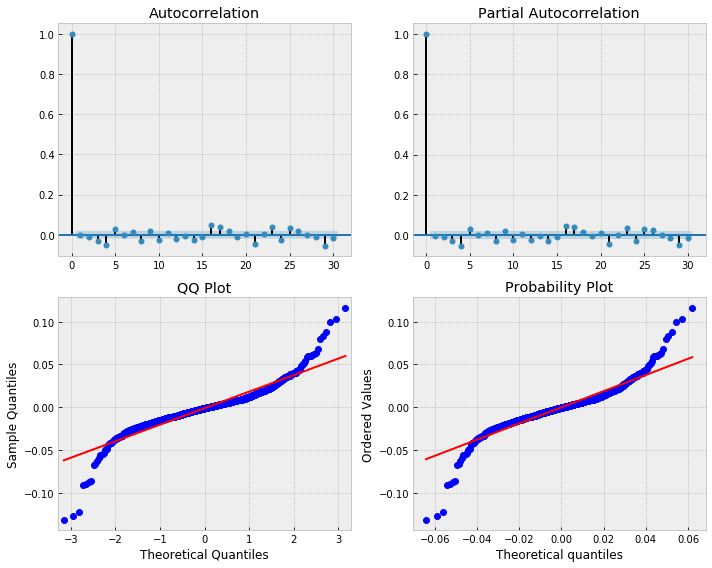

In [59]:
print (mdl_dict['AMZN'].summary())
tsplot(mdl_dict['AMZN'].resid, lags=30, name='Amazon')

                              ARMA Model Results                              
Dep. Variable:               Freturns   No. Observations:                 1258
Model:                     ARMA(2, 2)   Log Likelihood                3539.879
Method:                           mle   S.D. of innovations              0.014
Date:                Wed, 08 Jan 2020   AIC                          -7069.759
Time:                        12:28:35   BIC                          -7044.072
Sample:                             0   HQIC                         -7060.105
                                                                              
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
ar.L1.Freturns     0.7604      0.006    117.091      0.000       0.748       0.773
ar.L2.Freturns    -0.9826      0.006   -164.784      0.000      -0.994      -0.971
ma.L1.Freturns    -0.7524      0.003

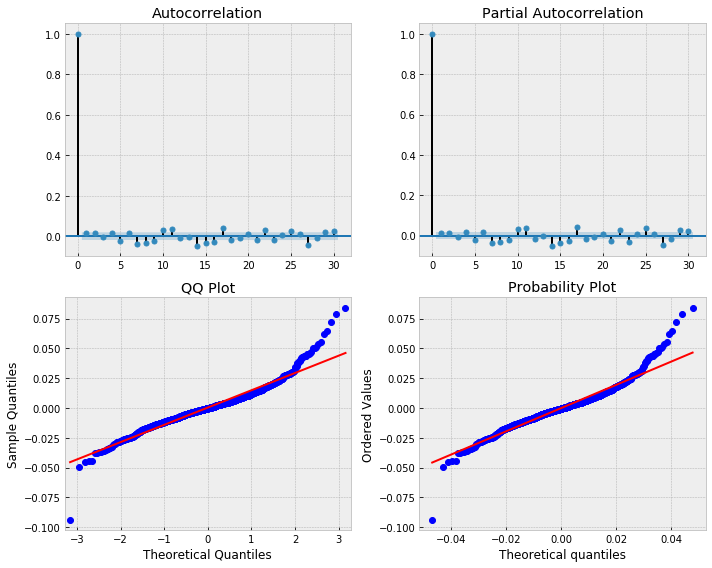

In [60]:
print (mdl_dict['F'].summary())
tsplot(mdl_dict['F'].resid, lags=30, name='Ford')

                             ARIMA Model Results                              
Dep. Variable:            D.GEreturns   No. Observations:                 1257
Model:                 ARIMA(5, 1, 2)   Log Likelihood                3457.995
Method:                           mle   S.D. of innovations              0.015
Date:                Wed, 08 Jan 2020   AIC                          -6899.989
Time:                        12:28:41   BIC                          -6858.897
Sample:                             1   HQIC                         -6884.546
                                                                              
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
ar.L1.D.GEreturns    -0.8735      0.090     -9.660      0.000      -1.051      -0.696
ar.L2.D.GEreturns     0.0361      0.038      0.953      0.341      -0.038       0.110
ar.L3.D.GEreturns     0.

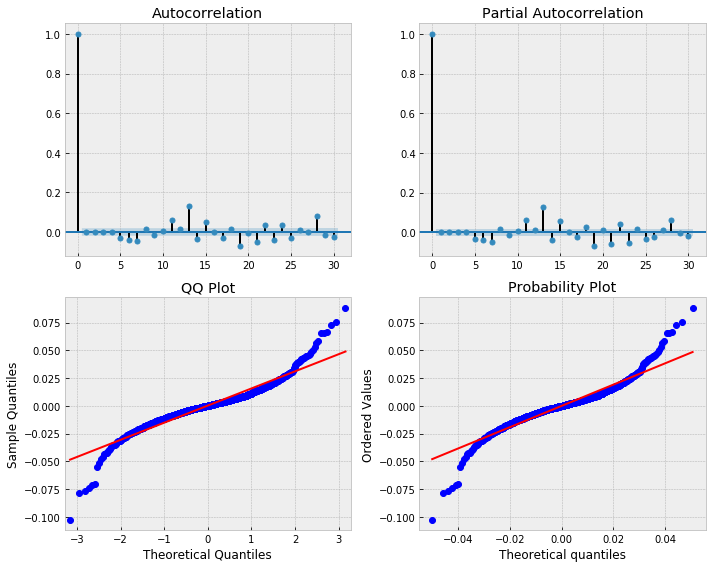

In [61]:
print (mdl_dict['GE'].summary())
tsplot(mdl_dict['GE'].resid, lags=30, name='General Electric')

                              ARMA Model Results                              
Dep. Variable:             CATreturns   No. Observations:                 1258
Model:                     ARMA(1, 0)   Log Likelihood                3411.464
Method:                           mle   S.D. of innovations              0.016
Date:                Wed, 08 Jan 2020   AIC                          -6818.929
Time:                        12:28:54   BIC                          -6808.654
Sample:                             0   HQIC                         -6815.067
                                                                              
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
ar.L1.CATreturns     0.0360      0.028      1.278      0.201      -0.019       0.091
                                    Roots                                    
                  Real          Ima

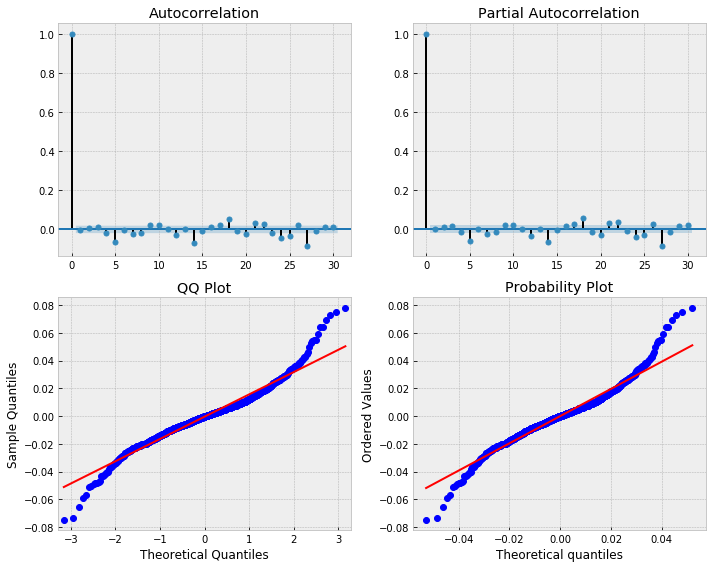

In [62]:
print (mdl_dict['CAT'].summary())
tsplot(mdl_dict['CAT'].resid, lags=30, name='Caterpillar')

From these figures one can see that there is almost none autocorrelation in the residuals. This should be checked by Ljung_box test

**Ljung-Box test**

In [63]:
ljung_box = {}
for symbol in tickers:
    ljung_box[symbol] = acorr_ljungbox(mdl_dict['GE'].resid, lags=15)[1]

In [64]:
ljung_box

{'AMZN': array([9.84465851e-01, 9.99728314e-01, 9.99836186e-01, 9.99992357e-01,
        9.43086331e-01, 7.84106634e-01, 5.52711538e-01, 6.29183101e-01,
        6.94970033e-01, 7.73413033e-01, 4.05330796e-01, 4.58735078e-01,
        1.46171071e-03, 1.49135187e-03, 7.98802824e-04]),
 'GE': array([9.84465851e-01, 9.99728314e-01, 9.99836186e-01, 9.99992357e-01,
        9.43086331e-01, 7.84106634e-01, 5.52711538e-01, 6.29183101e-01,
        6.94970033e-01, 7.73413033e-01, 4.05330796e-01, 4.58735078e-01,
        1.46171071e-03, 1.49135187e-03, 7.98802824e-04]),
 'F': array([9.84465851e-01, 9.99728314e-01, 9.99836186e-01, 9.99992357e-01,
        9.43086331e-01, 7.84106634e-01, 5.52711538e-01, 6.29183101e-01,
        6.94970033e-01, 7.73413033e-01, 4.05330796e-01, 4.58735078e-01,
        1.46171071e-03, 1.49135187e-03, 7.98802824e-04]),
 'CAT': array([9.84465851e-01, 9.99728314e-01, 9.99836186e-01, 9.99992357e-01,
        9.43086331e-01, 7.84106634e-01, 5.52711538e-01, 6.29183101e-01,
        

We cannot reject the null hypothesis that the residuals are white noise at 95% confidence level.

**ARMA predictions**

In [65]:
for symbol in ['GE','AMZN','F','CAT']:
        fig = go.Figure()
        ts = returns['%sreturns' % symbol].iloc[-255:-1].copy()
        pred = mdl_dict[symbol].predict()[-255:-1]
        n_steps=30
        f, err95, ci95 = mdl_dict[symbol].forecast(steps=n_steps) # 95% CI
        _, err99, ci99 = mdl_dict[symbol].forecast(steps=n_steps, alpha=0.01) # 99% CI
        idx = pd.date_range(returns.index[-1], periods=n_steps, freq='D')
        fc_95 = pd.DataFrame(np.column_stack([f, ci95]), index=idx, columns=['forecast', 'lower_ci_95', 'upper_ci_95'])
        fc_99 = pd.DataFrame(np.column_stack([ci99]), index=idx, columns=['lower_ci_99', 'upper_ci_99'])
        fc_all = fc_95.combine_first(fc_99)
        fc_all.index = pd.to_datetime(fc_all.index)

        fig.add_trace(go.Scatter(x=ts.index, y=ts.values,fill=None,mode='lines',line_color='blue',name='%s Returns' % symbol))

        fig.add_trace(go.Scatter(x=pred.index, y=pred.values,fill=None,mode='lines',line_color='yellow',name='Sample Prediction'))

        


        fig.add_trace(go.Scatter(x=fc_all.index, y=fc_all.upper_ci_95,fill=None,line_color='black',name='Upper_CI_95'))
        fig.add_trace(go.Scatter(x=fc_all.index,y=fc_all.lower_ci_95,fill='tonexty',mode='lines', line_color='black',name='Lower_CI_95'))

        fig.add_trace(go.Scatter(x=fc_all.index, y=fc_all.upper_ci_99,fill=None,mode='lines',line_color='gray',name='Upper_CI_99'))
        fig.add_trace(go.Scatter(x=fc_all.index,y=fc_all.lower_ci_99,fill='tonexty',mode='lines', line_color='gray',name='Lower_CI_99'))

        fig.add_trace(go.Scatter(x=fc_all.index,y=fc_all.forecast,fill=None,mode='lines',line_color='red',name='Forecast'))
        
        fig.update_layout(title='{} Day {} Return Forecast\nARIMA{}'.format(n_steps, symbol, order_dict[symbol]),
                      xaxis_title='Date Range',
                      yaxis_title='Returns',
                     height=400, width=1000,
                     legend=dict(x=-.25, y=1.6))
    
        fig.update_layout(
                    title={
                        'y':0.85,
                        'x':0.5,
                        'xanchor': 'center',
                        'yanchor': 'top'})


        fig.show()
    

We need to collect more data for GE in order to model its returns with ARMA rather than ARIMA.

While predicting returns for the assets, one can also notice that there are volatility clusters meaning that we need to use Generalized Autoregressive Conditional Heteroskedasticity (GARCH) model. Often, GARCH model is applied to ARIMA residuals to tackle this problem, while such an approach is not self-consistent. In order to make the predictions self-consistent, one needs to model return-series with ARMA-GARCH model. However, there is no such a library in Python. In order to get a better result we need to create ARMA-GARCH model ourselves. However, it is not a trivial task and goes beyond the scope of this work. This is one of possible cases for futher improvement of the solution.

We are not going to develop ARMA-GARCH approach here, but we can predict asset prices by using machine learning technique. Ridge and Lasso algorithms will be used for this purpose.

# Hybrid Machine Learning with Time Series

## Data preprocessing, cross-validation, adjustment of model hyperparameters
**There is also metrics and model selection**

**Adjusted close price predictions with Ridge and Lasso**

Before making any predictions, let's first indroduce several functions which will be useful in our modelling as well as grid parameters for Ridge and Lasso.
Many functions and approaches are taken from:

In [66]:
# function to split the dataset into train and test
def timeseries_train_test_split(X, y, test_size):
    
    # get the index after which test set starts
    test_index = int(len(X)*(1-test_size))
    
    X_train = X.iloc[:test_index]
    y_train = y.iloc[:test_index]
    X_test = X.iloc[test_index:]
    y_test = y.iloc[test_index:]
    
    return X_train, X_test, y_train, y_test

In [67]:

def prepareData(series, lag_start=1, lag_end=20, test_size=0.2):
    
    # copy of the initial dataset
    data = pd.DataFrame(series.copy())
    data.columns = ["y"]
    
    # lags of series
    for i in range(lag_start, lag_end):
        data["lag_{}".format(i)] = data.y.shift(i)
    
    # datetime features
    data['year'] = data.index.year
    data['month'] = data.index.month
    data['day'] = data.index.day
    data['weekday'] = data.index.weekday
    data['season'] = data['month'].apply(lambda x: '1' if x in [12,1,2] else\
                                         ('2' if x in [3,4,5] else ('3' if x in [6,7,8] else '4')))
    
    time_feat = ['year','month','day','weekday','season']
    time_feat_df = pd.DataFrame(data[time_feat], index=data.index)
    time_feat_df[time_feat] = time_feat_df[time_feat].astype('str')
    time_feat_df = pd.get_dummies(time_feat_df)
    data = pd.concat((data, time_feat_df), axis=1)
    data.drop(columns=time_feat, inplace=True)
    
    y = data.dropna().y
    X = data.dropna().drop(['y'], axis=1)
    X_train, X_test, y_train, y_test = timeseries_train_test_split(X, y, test_size=test_size)

    return X_train, X_test, y_train, y_test

In [68]:
# perform scaling of features
def feature_scaling(series, lag_start=1, lag_end=20, test_size=0.2):
    
    X_train, X_test, y_train, y_test = prepareData(series, lag_start=lag_start, \
                                                   lag_end=lag_end, test_size=test_size)
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    return X_train_scaled, X_test_scaled, y_train, y_test

In [69]:
time_split = TimeSeriesSplit(n_splits=3)

In [70]:
def grid_search(estimator, X, y, grid_param, scoring='neg_mean_absolute_error', idd=False, cv=time_split):
    
    gsearch = GridSearchCV(estimator = estimator, 
                           param_grid = grid_param, 
                           scoring=scoring,
                           iid=idd, 
                           cv=cv,
                           n_jobs=-1,
                           verbose=True)
    gsearch.fit(X, y)        
    return gsearch

In [71]:
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [72]:
def prediction_plot(Model,X_test, y_Test,asset_name = ''):
    prediction = Model.predict(X_test)
    prediction=pd.DataFrame(prediction,columns=['val'])
    y_test=pd.DataFrame(y_Test)
    error = mean_absolute_percentage_error(y_test.values, prediction.values)
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=y_test.index, y=prediction.val,
                             fill=None,
                             mode='lines',
                             line_color='black',
                             name="%s prediction" %asset_name
                             ))
    
    fig.add_trace(go.Scatter(x=y_test.index,y= y_test.y,
                             fill=None,
                             mode='lines',
                             line_color='yellow',
                             name="actual"
                            ))
  

    
    fig.update_layout(title="Mean absolute percentage error {0:.2f}%".format(error),
                      xaxis_title='Index time',
                      yaxis_title='Closing Stocks',
                     height=600, width=1000,
                     legend=dict(x=-.05, y=1.4))
    
    fig.update_layout(
                    title={
                        'y':0.80,
                        'x':0.5,
                        'xanchor': 'center',
                        'yanchor': 'top'})
    
    fig.update_xaxes(showgrid=False)
    fig.update_yaxes(showgrid=False)
    fig.show()

**Hyperparameters for grid search**

In [73]:
param_ridge = {'alpha': [25,10,4,2,1.0,0.8,0.5,0.3,0.2,0.1,0.05,0.02,0.01]}
param_lasso = {'alpha': [25,10,4,2,1.0,0.8,0.5,0.3,0.2,0.1,0.05,0.02,0.01]}

### Predictions for hold-out samples

In [74]:
X_AMZN_train_scaled, X_AMZN_test_scaled, y_AMZN_train, y_AMZN_test = feature_scaling(adj_close.AMZNClose)

In [75]:
[(el[0].shape, el[1].shape) for el in time_split.split(X_AMZN_train_scaled)]

[((248,), (248,)), ((496,), (248,)), ((744,), (248,))]

## AMAZON Prediction
**AMAZON RIDGE**

In [76]:
ridge_AMZN = grid_search(estimator = Ridge(),
                      X=X_AMZN_train_scaled, 
                      y=y_AMZN_train,
                      grid_param=param_ridge,
                      cv=time_split)

Fitting 3 folds for each of 13 candidates, totalling 39 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  32 out of  39 | elapsed:    4.3s remaining:    0.9s
[Parallel(n_jobs=-1)]: Done  39 out of  39 | elapsed:    4.3s finished


In [77]:
prediction_plot(ridge_AMZN, X_AMZN_test_scaled, y_AMZN_test, asset_name='Amazon Ridge')

**AMAZON LASSO**

In [78]:
lasso_AMZN = grid_search(estimator = Lasso(),
                       X=X_AMZN_train_scaled, 
                      y=y_AMZN_train,
                      grid_param=param_lasso,
                      cv=time_split)

Fitting 3 folds for each of 13 candidates, totalling 39 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  39 out of  39 | elapsed:    0.2s finished


In [79]:
prediction_plot(lasso_AMZN, X_AMZN_test_scaled, y_AMZN_test, asset_name='Amazon Lasso')

## FORD Prediction
**FORD RIDGE**

In [80]:
X_F_train_scaled, X_F_test_scaled, y_F_train, y_F_test = feature_scaling(adj_close.FClose)

In [81]:
[(el[0].shape, el[1].shape) for el in time_split.split(X_F_train_scaled)]

[((248,), (248,)), ((496,), (248,)), ((744,), (248,))]

In [82]:
ridge_F = grid_search(estimator = Ridge(),
                      X=X_F_train_scaled, 
                      y=y_F_train,
                      grid_param=param_ridge)

Fitting 3 folds for each of 13 candidates, totalling 39 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  39 out of  39 | elapsed:    0.0s finished


In [83]:
prediction_plot(ridge_F, X_F_test_scaled, y_F_test, asset_name='Ford Ridge')

**FORD LASSO**

In [84]:
lasso_F = grid_search(estimator = Lasso(),
                      X=X_F_train_scaled, 
                      y=y_F_train,
                      grid_param=param_lasso,
                      cv=time_split)

Fitting 3 folds for each of 13 candidates, totalling 39 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  39 out of  39 | elapsed:    0.0s finished


In [85]:
prediction_plot(lasso_F, X_F_test_scaled, y_F_test,asset_name='Ford Lasso')

## GE Prediction
**GE RIDGE**

In [86]:
X_GE_train_scaled, X_GE_test_scaled, y_GE_train, y_GE_test = feature_scaling(adj_close.GEClose)

In [87]:
ridge_GE = grid_search(estimator = Ridge(),
                      X=X_GE_train_scaled, 
                      y=y_GE_train,
                      grid_param=param_ridge)

Fitting 3 folds for each of 13 candidates, totalling 39 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  39 out of  39 | elapsed:    0.0s finished


In [88]:
prediction_plot(ridge_GE, X_GE_test_scaled, y_GE_test,asset_name='GE Ridge')

**GE LASSO**

In [89]:
lasso_GE = grid_search(estimator = Lasso(),
                      X=X_GE_train_scaled, 
                      y=y_GE_train,
                      grid_param=param_lasso,
                      cv=time_split)

Fitting 3 folds for each of 13 candidates, totalling 39 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  39 out of  39 | elapsed:    0.1s finished


In [90]:
prediction_plot(lasso_GE, X_GE_test_scaled, y_GE_test,asset_name='GE Lasso')

# LSTM Architecture

## Close Volume insights and library upload

In [91]:
import math
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import *
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from keras.callbacks import EarlyStopping

Using TensorFlow backend.


In [92]:
print( 'Kurtosis of normal distribution: {}'.format(scs.kurtosis(adj_close.FClose)))
print( 'Skewness of normal distribution: {}'.format(scs.skew(adj_close.FClose)))

Kurtosis of normal distribution: -0.7750353389413496
Skewness of normal distribution: 0.04280290656796982


In [113]:
v_features=list(adj_close.columns)
print(v_features)
v_features=['FClose']

['CATClose', 'FClose', 'GEClose', 'AMZNClose']


In [114]:
import plotly.figure_factory as ff
import numpy as np


for i, cn in enumerate(adj_close[v_features[:]]):
        group_labels = ['Stocks']

        colors = ['magenta']
        x1 = adj_close[cn]

# Create distplot with curve_type set to 'normal'
        fig = ff.create_distplot([x1], group_labels, bin_size=1,
                         curve_type='normal', # override default 'kde'
                         colors=colors)

# Add title
        fig.update_layout(title_text='Distplot with Normal Distribution '+str(cn))
        fig.show()

## Data Creation for Training

In [99]:
dataset = adj_close.FClose.values #numpy.ndarray
dataset = dataset.astype('float32')
dataset = np.reshape(dataset, (-1, 1))
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)
train_size = int(len(dataset) * 0.80)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

- **We can use TimeSeries Generator to make the datasets for LSTM**
- **convert an array of values into a dataset matrix**

In [100]:
def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        X.append(a)
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)

In [101]:
# reshape into X=t and Y=t+1 
look_back = 12
X_train, Y_train = create_dataset(train, look_back)
X_test, Y_test = create_dataset(test, look_back)

**here lookback means it will see previous 12 monsth data to predict 13th month to capture Seasonality**

In [102]:
print(X_train.shape,Y_train.shape)

(995, 12) (995,)


In [103]:
# reshape input to be [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

In [104]:
print(X_train.shape,Y_train.shape)

(995, 1, 12) (995,)


**Above (Samples,n_features,Timestep)**
- Samples =Number of Rows
- n_features= Number of Columns
- Timestep= Lookback how many Months

## Model Training

In [105]:
model = Sequential()
model.add(LSTM(360,activation='relu',input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.30))


model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

history = model.fit(X_train, Y_train, epochs=50, batch_size=32, validation_data=(X_test, Y_test), 
                    callbacks=[EarlyStopping(monitor='val_loss', patience=10)], verbose=1, shuffle=False)

# Training Phase
model.summary()

W0108 12:37:25.331065 20956 deprecation_wrapper.py:119] From C:\Users\aniruddha.choudhury\AppData\Local\Continuum\anaconda3\envs\kdlsd\lib\site-packages\keras\backend\tensorflow_backend.py:66: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0108 12:37:25.355057 20956 deprecation_wrapper.py:119] From C:\Users\aniruddha.choudhury\AppData\Local\Continuum\anaconda3\envs\kdlsd\lib\site-packages\keras\backend\tensorflow_backend.py:541: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0108 12:37:25.358062 20956 deprecation_wrapper.py:119] From C:\Users\aniruddha.choudhury\AppData\Local\Continuum\anaconda3\envs\kdlsd\lib\site-packages\keras\backend\tensorflow_backend.py:4432: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0108 12:37:25.907062 20956 deprecation_wrapper.py:119] From C:\Users\aniruddha.choudhury\AppData\Local\Continuum\anaconda3\envs\kdlsd\lib\site-packages\ke

Train on 995 samples, validate on 239 samples
Epoch 1/50
995/995 [==============================] - 2s 2ms/step - loss: 0.1338 - val_loss: 0.0074
Epoch 2/50
995/995 [==============================] - 1s 827us/step - loss: 0.0076 - val_loss: 0.0019
Epoch 3/50
995/995 [==============================] - 1s 876us/step - loss: 0.0044 - val_loss: 0.0028
Epoch 4/50
995/995 [==============================] - 1s 762us/step - loss: 0.0033 - val_loss: 0.0027
Epoch 5/50
995/995 [==============================] - 1s 860us/step - loss: 0.0036 - val_loss: 0.0024
Epoch 6/50
995/995 [==============================] - 1s 805us/step - loss: 0.0036 - val_loss: 0.0024
Epoch 7/50
995/995 [==============================] - 1s 774us/step - loss: 0.0038 - val_loss: 0.0023
Epoch 8/50
995/995 [==============================] - 1s 833us/step - loss: 0.0037 - val_loss: 0.0023
Epoch 9/50
995/995 [==============================] - 1s 739us/step - loss: 0.0034 - val_loss: 0.0023
Epoch 10/50
995/995 [=================

## LSTM Model Evaluation & Visualization

In [106]:
# make predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)
# invert predictions
train_predict = scaler.inverse_transform(train_predict)
Y_train = scaler.inverse_transform([Y_train])
test_predict = scaler.inverse_transform(test_predict)
Y_test = scaler.inverse_transform([Y_test])

print('Train Mean Absolute Error:', mean_absolute_error(Y_train[0], train_predict[:,0]))
print('Train Root Mean Squared Error:',np.sqrt(mean_squared_error(Y_train[0], train_predict[:,0])))
print('Test Mean Absolute Error:', mean_absolute_error(Y_test[0], test_predict[:,0]))
print('Test Root Mean Squared Error:',np.sqrt(mean_squared_error(Y_test[0], test_predict[:,0])))

Train Mean Absolute Error: 0.36207795291970873
Train Root Mean Squared Error: 0.46501018004441647
Test Mean Absolute Error: 0.3800813022597066
Test Root Mean Squared Error: 0.4754498667963409


In [107]:
def Model_Loss_plot(history,asset_name = ''): 
    Trainloss=pd.DataFrame(history.history['loss'],columns=['Train_Loss'])
    Valloss=pd.DataFrame(history.history['val_loss'],columns=['Val_Loss'])

   
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=Trainloss.index, y=Trainloss.Train_Loss,
                             fill=None,
                             mode='lines',
                             line_color='black',
                             name="%s Train Loss" %asset_name
                             ))
    
    fig.add_trace(go.Scatter(x=Valloss.index,y= Valloss.Val_Loss,
                             fill=None,
                             mode='lines',
                             line_color='yellow',
                             name="%s Test Loss" %asset_name
                            ))
  

    fig.update_layout(title="LSTM Prediction of model loss %s " %asset_name,
                      xaxis_title='epochs',
                      yaxis_title='loss',
                     height=600, width=1000,
                     legend=dict(x=-.05, y=1.4))
    
    fig.update_layout(
                    title={
                        'y':0.80,
                        'x':0.5,
                        'xanchor': 'center',
                        'yanchor': 'top'})
    
    fig.update_xaxes(showgrid=False)
    fig.update_yaxes(showgrid=False)
    fig.show()

In [108]:
Model_Loss_plot(history,asset_name = 'Ford')

In [109]:
def prediction_LSTM(test_predict, y_test,asset_name = ''):
    Y_test_transpose=pd.DataFrame(y_test).T
    Y_test_transpose.columns=['Real']
    prediction=pd.DataFrame(test_predict,columns=['pred'])
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=Y_test_transpose.index, y=prediction.pred,
                             fill=None,
                             mode='lines',
                             line_color='black',
                             name="%s prediction" %asset_name
                             ))
    
    fig.add_trace(go.Scatter(x=Y_test_transpose.index,y= Y_test_transpose.Real,
                             fill=None,
                             mode='lines',
                             line_color='yellow',
                             name="actual"
                            ))
  

    
    fig.update_layout(title="LSTM Prediction of %s " %asset_name,
                      xaxis_title='Time Step',
                      yaxis_title='Closing Stocks',
                     height=600, width=1000,
                     legend=dict(x=-.05, y=1.4))
    
    fig.update_layout(
                    title={
                        'y':0.80,
                        'x':0.5,
                        'xanchor': 'center',
                        'yanchor': 'top'})
    
    fig.update_xaxes(showgrid=False)
    fig.update_yaxes(showgrid=False)
    fig.show()

In [110]:
prediction_LSTM(test_predict, Y_test,asset_name = 'Ford')

The Model is predicting pretty good with .47 **RMSE** consider that we can predict for Similar for other Company.